# NUISANCE3 GENIE Data Comparison Tutorial

In this tutorial we will work through generating/reading/analysing and comparing some GENIE predictions to some MINERvA data. We will also show how `nusystematics` can be used to reweight those predictions to mock up the effect of varying physics parameters in the model.

In [1]:
import pyNUISANCE as pn
import matplotlib.pyplot as plt

Nuisance: Neutrino Interaction Synthesiser ANalyser by Comparing Experiments  -- Fit and compare.
[ NUISANCE ]: Loading DEFAULT settings from : /root/software/NUISANCEMC/nuisance/build/Linux/parameters/config.xml
[ NUISANCE ]: Finished nuisconfig.
Welcome to JupyROOT 6.30/04


# Generate Some Events

We'd like to generate some events to use for later analysis. We can do this without leaving Jupyter by using some bash cell magic.

First check that some relevant environment variables are set.

In [2]:
%%bash
echo $GENIE_XSEC_TUNE
echo $GENIE_XSEC_FILE

AR23_20i_00_000
/opt/genie_xsec/3_04_00/AR23_20i_00_000/gxspl-min.xml.gz


Then generate some events with `gevgen`, we will use a CH target, which can be specified as: `1000060120[12],1000010010[1.00784]`. We will ask NUISANCE2 for the flux specification.

In [3]:
%%bash
# uncomment to force regeneration
# rm genie_CH.MINERvA_LE.ghep.root
if [ ! -e genie_CH.MINERvA_LE.ghep.root ]; then
    gevgen -e 0.1,10 \
           -f $($NUISANCE/bin/nuis-flux MINERvA -P numu -M nu) \
           -p 14 -t 1000060120[12],1000010010[1.00784] \
           -n 500000 \
           --tune $GENIE_XSEC_TUNE --cross-sections $GENIE_XSEC_FILE \
           --event-generator-list Default \
           -o genie_CH.MINERvA_LE.ghep.root &> genie.run.log
  if [ "$?" != 0 ]; then
    head -200 genie.run.log
  fi
fi

See the GENIE Physics and User manual for more information on using `gevgen`: https://www.overleaf.com/project/636a7db08c037d85efd5b1a2

# Read in the Events

To read in a stream of events in pyNUISANCE (NUISANCE3), we use an `EventSource`. This can be passed a filepath as a string and it will attempt to read the pointed to file. NUISANCE3 can read a variety of formats via plugins, which plugins are available depend on the generator libraries found when NUISANCE was built. Specific plugins sometimes require more information than just the filepath, alternatively, as below, a dictionary of information can be passed to `EventSource`. Below we see that to read the GENIE file that we just generated, we need to tell NUISANCE some extra information about the generation, this is so that NUISANCE can determine the Flux-Averaged Total Cross Section (FATX) for the generator run. If you are used to NUISANCE2, the FATX/number of events is equivalent to the `fScaleFactor` that you may have to use to correctly normalize event predictions. In NUISANCE3 we use the sum of the event weights, rather than just the number of events in the denominator, to account for event generators that produce weighted samples.

In [4]:
gevs = pn.EventSource({"event-generator-list":"Default",
                       "tune":"AR23_20i_00_000",
                       "spline_file":"/opt/genie_xsec/3_04_00/AR23_20i_00_000/gxspl-min.xml.gz",
                       "filepath": "genie_CH.MINERvA_LE.ghep.root"})
if not gevs:
    print("Failed to read event file")

1734561943 NOTICE Messenger : [s] <SetPrioritiesFromXmlFile (136)> : Reading msg stream priorities from XML file: /opt/genie/3_04_02/config/Messenger.xml
1734561943 INFO TuneId : [n] <TuneId.cxx::Build (132)> : AR23_20i_00_000 Tune configured 
1734561943 INFO RunOpt : [n] <RunOpt.cxx::BuildTune (94)> : Building tune AR23_20i_00_000
1734561943 INFO TuneId : [n] <TuneId.cxx::Build (132)> : AR23_20i_00_000 Tune configured 
1734561943 INFO TransverseEnhancementFFModel : [n] <ConfigIsotopeMapUtils.cxx::LoadAllNucARangesForKey (61)> : For 0 < A < 12 -> using MagFF_RT_A = 0
1734561943 INFO TransverseEnhancementFFModel : [n] <ConfigIsotopeMapUtils.cxx::LoadAllNucARangesForKey (61)> : For 11 < A < 420 -> using MagFF_RT_A = 5.19
1734561943 INFO TransverseEnhancementFFModel : [n] <ConfigIsotopeMapUtils.cxx::LoadAllNucARangesForKey (61)> : For 0 < A < 12 -> using MagFF_RT_B = 1
1734561943 INFO TransverseEnhancementFFModel : [n] <ConfigIsotopeMapUtils.cxx::LoadAllNucARangesForKey (61)> : For 11 < A

By default, NUISANCE3 will refuse to read in events that it cannot determine the FATX for. If you want to read such events, you can use an `UnNormalizedEventSource` and then provide an FATX externally. The reason that this approach is more involved is becuase knowing the FATX for an input file is critical to almost all of the NUISANCE's function and so forcing through an un-normalisable file is an expert operation.

In [5]:
# fgevs = pn.UnNormalizedEventSource("genie_CH.MINERvA_LE.ghep.root").force_fatx(1, pn.nhm.FATXUtils.cm2ten38_PerNucleon)

The stream of events retrieved from an `EventSource` is always in HepMC3 format, if the events on disk are no HepMC3 events then they are converted on the fly. A python event loop might be written as follows:

```python
for ev, w in gevs:
  #do something with each event
```

You can find more out about HepMC3 here: https://gitlab.cern.ch/hepmc/HepMC3

However, we do not recommend using python event loops for analysis, so read on for the preferred workflow.

# Do some analysis

NUISANCE3 python analyses follow a 'dataframe' or 'columnar' workflow. The input event stream is converted to tabular data where each row corresponds to a single event and each column corresponds to some event property or projection of the event. An `EventFrameGen` is used to define and then execute this workflow.

Below we can see the columns that all `EventFrame`s contain by default.

In [6]:
ef = pn.EventFrameGen(gevs).first(20)
print(ef)

 -----------------------------------------------------------------------
 | event.number | weight.cv | fatx_per_su$ | fatx_per_su$ | process.id |
 -----------------------------------------------------------------------
 |            0 |         1 |       0.3827 |      0.03189 |        400 |
 |            1 |         1 |       0.1882 |      0.01568 |        300 |
 |            2 |         1 |      0.01825 |     0.009215 |        500 |
 |            3 |         1 |      0.01761 |     0.007658 |        200 |
 |            4 |         1 |      0.01654 |     0.005667 |        300 |
 |            5 |         1 |      0.01588 |     0.004848 |        500 |
 |            6 |         1 |      0.01512 |     0.004081 |        650 |
 |            7 |         1 |      0.01491 |     0.003942 |        600 |
 |            8 |         1 |      0.01439 |     0.003539 |        500 |
 |            9 |         1 |      0.01401 |     0.003284 |        600 |
 |           10 |         1 |      0.01364 |     0.

Every `EventFrame` contains running normalisation information so that a correct cross section prediction easily with a subset of the input event stream (providing that every event starting from the first one is considered). It also contains the generator-dependent `process_id`. If these Id's are 3 digits, they may follow the NuHepMC specification: `E.C.1` from https://arxiv.org/pdf/2310.13211

The canonical way to check if E.C.1 is being followed is to check the `NuHepMC.Conventions` attribute on the `HepMC3::GenRunInfo`, if it contains `E.C.1` then it is likely that it is being followed.

In [7]:
gevs.run_info().attribute_as_string("NuHepMC.Conventions")

'G.C.1 G.C.2 G.C.4 E.C.1 V.C.1 P.C.1 P.C.2 E.C.2'

`EventFrameGen` support both complete or batched processing depending on file size and memory pressure. An example of batched processing would be:

```python
evf = pn.EventFrameGen(gevs)
# Add some columns to evf
ef_batch = evf.first(20)
while ef_batch:
  # do some analysis on the EventFrame batch
  ef_batch = evf.next(20)
```

For the rest of this tutorial we will produce and consume the entire `EventFrame` in one go, like:

```python
evf = pn.EventFrameGen(gevs)
# Add some columns to evf
ef = evf.all()
```

## Columnar Analysis

New columns for processing are defined by a name and a function that takes a HepMC3 event and returns a single number (which will be converted to a double as needed). These functions can be written in python or ProSelecta (https://github.com/NUISANCEMC/ProSelecta/blob/main/README.md) can be used to write them in C++, compile them, and generate python handles to them. For clarity in this tutorial we will write them in python using `pyProSelecta` helper functions where neccessary.

We will add a few simple column functions that might be useful for a pion analysis.

In [8]:
from pyProSelecta import event, part, unit, pdg, p3mod, momentum, ext
from pyNuHepMC import EventUtils
from pyHepMC3.pyHepMC3.HepMC3 import FourVector

def numpi(ev):
    return event.num_out_part(ev, [211,-211,111], flatten=True)

def invariant_hadronic_mass(ev):
    # get the hard scatter vertex
    pv = EventUtils.GetPrimaryVertex(ev)
    p4 = FourVector(0,0,0,0)
    # sum all non lepton out-going particles
    for p in pv.particles_out():
        pid_abs = abs(p.pid())
        if (pid_abs > 16) and (pid_abs < 1000000000):
            p4 = p4 + p.momentum()
    return p4.m() / unit.GeV_c2

efg = pn.EventFrameGen(gevs) \
        .add_column("enu", ext.enu_GeV) \
        .add_column("q0",ext.q0lep_GeV) \
        .add_column("q3",ext.q3lep_GeV) \
        .add_column("Q2", ext.Q2lep_GeV2) \
        .add_column("W_vtx", invariant_hadronic_mass) \
        .add_column("numpi", numpi) \

print(efg.first(20))

 -----------------------------------------------------------------------------------------------------------------------------
 | event.number | weight.cv | fatx_per_su$ | fatx_per_su$ | process.id |   enu |     q0 |     q3 |       Q2 |  W_vtx | numpi |
 -----------------------------------------------------------------------------------------------------------------------------
 |            0 |         1 |       0.3827 |      0.03189 |        400 | 2.921 |  2.586 |  2.909 |    1.773 |  1.886 |     0 |
 |            1 |         1 |       0.1882 |      0.01568 |        300 | 2.815 | 0.2459 | 0.3617 |  0.07037 |      0 |     0 |
 |            2 |         1 |      0.01825 |     0.009215 |        500 | 2.486 | 0.8143 |  1.014 |   0.3658 |  1.429 |     2 |
 |            3 |         1 |      0.01761 |     0.007658 |        200 | 3.895 | 0.3345 | 0.8541 |   0.6177 | 0.9383 |     0 |
 |            4 |         1 |      0.01654 |     0.005667 |        300 | 2.019 | 0.2972 | 0.8309 |   0.6021 |  

We might want to only analyse a subset of the event stream, there are a number of ways that we can make cuts and they depend on what our onward analysis looks like. We can add a filter on the `EventGenFrame` which will stop events being processed at all if they are cut. Sometimes we may want to perform multiple, orthogonal analyses on a single input file. We can build an `EventFrame` for each analysis with different filters and columns, but it can also be useful to add 'flag' or 'category' columns that can later be used to divide up event samples.

Below, we will show an example of both, we will filter on events with 0 final state leptons (likely NC interactions), and then add a categorisation column which can be used to divide the sample into 5 categories based on the number and species of final state pions in an event.

In [9]:
def numclep(ev):
    return event.num_out_part(ev, pdg.kChargedLeptons, flatten=True)

def pioncategory(ev):
    npip, npim, npi0 = event.num_out_part(ev, [211,-211,111])
    npi = (npip+npim+npi0)

    if npi == 0:
        return 0
    elif npi == 1:
        if npip == 1:    
            return 1
        if npim == 1:    
            return 2
        if npi0 == 1:    
            return 3
    return 4

efg.filter(lambda ev: numclep(ev)).add_column("pioncategory", pioncategory)

ef = efg.all()
print(ef)

 --------------------------------------------------------------------------------------------------------------------------------------------
 | event.number | weight.cv | fatx_per_su$ | fatx_per_su$ | process.id |   enu |     q0 |     q3 |       Q2 |  W_vtx | numpi | pioncategory |
 --------------------------------------------------------------------------------------------------------------------------------------------
 |            0 |         1 |       0.3827 |      0.03189 |        400 | 2.921 |  2.586 |  2.909 |    1.773 |  1.886 |     0 |            0 |
 |            1 |         1 |       0.1882 |      0.01568 |        300 | 2.815 | 0.2459 | 0.3617 |  0.07037 |      0 |     0 |            0 |
 |            2 |         1 |      0.01825 |     0.009215 |        500 | 2.486 | 0.8143 |  1.014 |   0.3658 |  1.429 |     2 |            4 |
 |            3 |         1 |      0.01761 |     0.007658 |        200 | 3.895 | 0.3345 | 0.8541 |   0.6177 | 0.9383 |     0 |            0 |
 |    

Comparing the `event.number` column and the `process.id` column, we can see that some events don't make it into this filtered table at all, and there are no longer process ids of the form `x5x`, which in the NuHepMC convention correspond to NC channels.

The pioncategory column holds a labelling integer corresponding to the following topologies:
* 0: CC0Pi
* 1: CC1Pi+
* 2: CC1Pi-
* 3: CC1Pi0
* 4: CCNPi

Now we're ready to make some plots

## From EventFrames to HistFrames

NUISANCE3 comes with its own Histogramming library. The histogram type is called a `HistFrame`. It might initially be confusing that we have `EventFrames` and `HistFrames`, but they both end up being quite powerful for analysis. Remember, in an `EventFrames`, each row corresponds to an event and the different columns correspond to different event properties. In a `HistFrame`, each row corresponds to a bin, and each column corresponds to a distinct set of bin values and errors. You will see why this is a useful object soon.

First, lets just plot the neutrino energy distribution for our selected CC events. The python bindings for `HistFrame`s come with an interface to `matplotlib` to make rapid prototyping of analysis simple, for more complicated plots, you may need to take the values and bins from your `HistFrame` and plot them using the full `matplotlib` library.

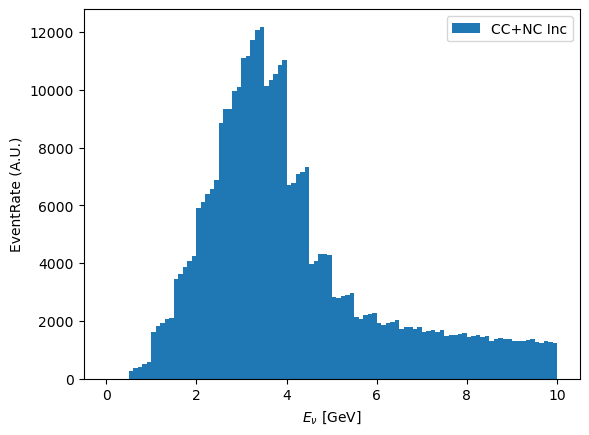

In [10]:
enu_h = pn.HistFrame(pn.Binning.lin_space(0,10,100,r"$E_{\nu}$ [GeV]"), "CC+NC Inc", "EventRate (A.U.)")
enu_h.fill(ef, "enu")
enu_h.mpl().hist()

plt.legend()
plt.show()

You can see that we have defined a simple uniform binning with `pn.Binning.lin_space` that takes arguments defining a start, stop, number of bins. We have annotated the axis with a label, the histogram with a title and a y-axis label, both can contain a subset of latex that matplotlib will render for you.

We then fill the histogram from the `EventFrame` specifying the name of the `EventFrame` column that we want to plot.

Simple!

There are a few ways that we can perform more-advanced `fill` operations with the same input `EventFrame`. We can use a column name as a boolean for wether to fill with an event property or not. Events with a value of 0 are skipped, those with any other value will be filled. Below we show how to make a version of the above plot that only contains events with pions. As we are now specifying a more complex fill operation, we have to be explicit about which `HistFrame` column to fill, which can be done by name or index. If a non-existant column name is passed to `fill_column`, then a new column will that name will be created and filled, as in the example below. We will then plot the first column, which was filled above, overlaid by the second column, which only contains events with one or more final state pion.

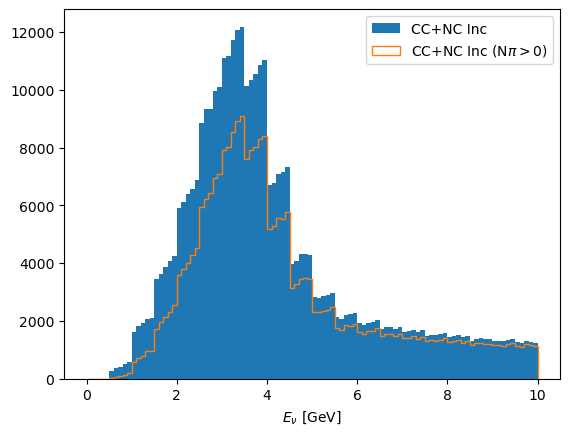

In [11]:
enu_h.fill(ef, "enu", [pn.HistFrame.fill_column("CC+NC Inc (N$\pi > 0)$"), pn.HistFrame.fill_if("numpi")])

enu_h.mpl().hist()
enu_h.mpl().hist(column="CC+NC Inc (N$\pi > 0)$", histtype="step")

plt.legend()
plt.show()

Beyond just using an `EventFrame` column as a cut, below we demonstrate using the `pioncategory` column to categorize events, and then the `hist_all` helper to plot all categories in one function call.

We will start with a fresh histogram, every event is used to fill the `"Total"` column, which is column 0, but they also fill a column from 1 to 5 based on the value of the `"pioncategory"` for that event.

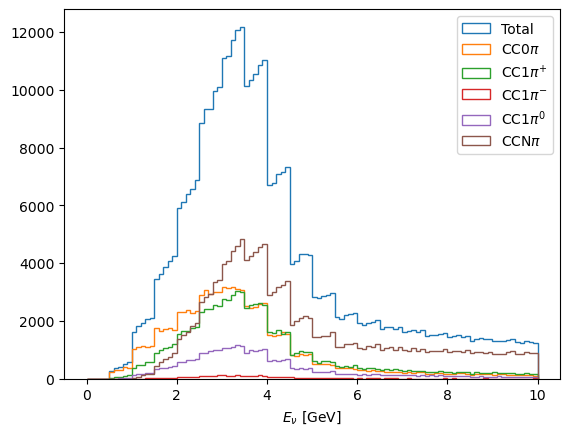

In [12]:
enu_h = pn.HistFrame(pn.Binning.lin_space(0,10,100,r"$E_{\nu}$ [GeV]"), "Total", "EventRate (A.U.)")
enu_h.fill(ef, "enu", [pn.HistFrame.fill_column("Total"), 
                       pn.HistFrame.categorize_by("pioncategory", 
                                                  ["CC0$\pi$", "CC1$\pi^{+}$", "CC1$\pi^{-}$", "CC1$\pi^{0}$", "CCN$\pi$"])])

enu_h.mpl().hist_all(histtype="step")

plt.legend()
plt.show()

You might think that the above plot looks odd. It is always a good idea when analysing a generation output for the first time to plot the neutrino energy distribution and check that it looks sensible, this can highland many bugs that might be harder to spot in different projections. Here, the saw-toothing is not ideal, but is expected from how GENIE throws events from a flux histogram.

Finally, in this section, we will use the pion category column to analyse the four momentum transfer and hadronic mass at the hard-scatter vertex of events containing pions. The example below will contain less commentary, but serves as a demo for what we can achieve with the NUISANCE3 `EventFrame`s, `HistFrame`s and a bit of `matplotlib`.

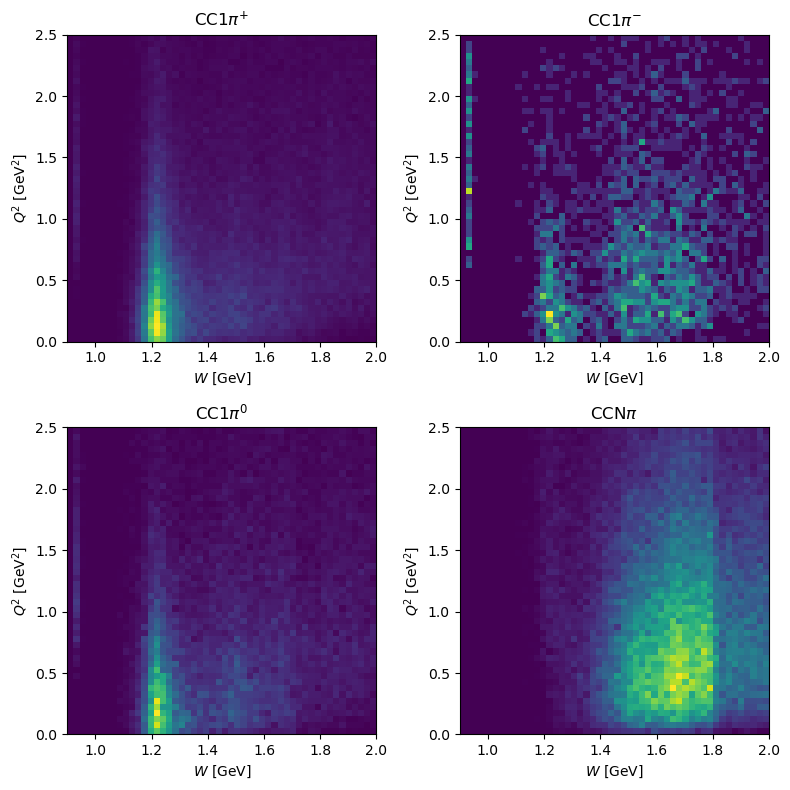

In [13]:
q0q3_h = pn.HistFrame(pn.Binning.lin_spaceND([[0.9,2,50],[0,2.5,50]],[r"$W$ [GeV]", r"$Q^{2}$ [GeV$^{2}$]"]), "Total", "EventRate (A.U.)")

q0q3_h.fill(ef, ["W_vtx", "Q2"], [pn.HistFrame.categorize_by("pioncategory", 
                                                  ["CC0$\pi$", "CC1$\pi^{+}$", "CC1$\pi^{-}$", "CC1$\pi^{0}$", "CCN$\pi$"]),])

fig, axes = plt.subplots(2,2, figsize=(8,8))

q0q3_h.mpl().colormesh(column="CC1$\pi^{+}$", plot_axis=axes[0][0])
plot_axis=axes[0][0].set_title("CC1$\pi^{+}$")

q0q3_h.mpl().colormesh(column="CC1$\pi^{-}$", plot_axis=axes[0][1])
plot_axis=axes[0][1].set_title("CC1$\pi^{-}$")

q0q3_h.mpl().colormesh(column="CC1$\pi^{0}$", plot_axis=axes[1][0])
plot_axis=axes[1][0].set_title("CC1$\pi^{0}$")

q0q3_h.mpl().colormesh(column="CCN$\pi$", plot_axis=axes[1][1])
plot_axis=axes[1][1].set_title("CCN$\pi$")

fig.tight_layout()
fig.show()

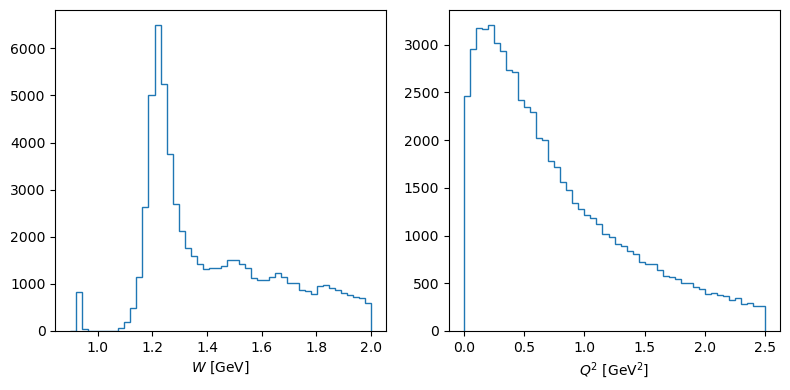

In [14]:
fig, axes = plt.subplots(1,2, figsize=(8,4))

q0q3_h.project(0).mpl().hist(histtype="step", plot_axis=axes[0], column="CC1$\pi^{+}$")
q0q3_h.project(1).mpl().hist(histtype="step", plot_axis=axes[1], column="CC1$\pi^{+}$")

fig.tight_layout()
plt.show()

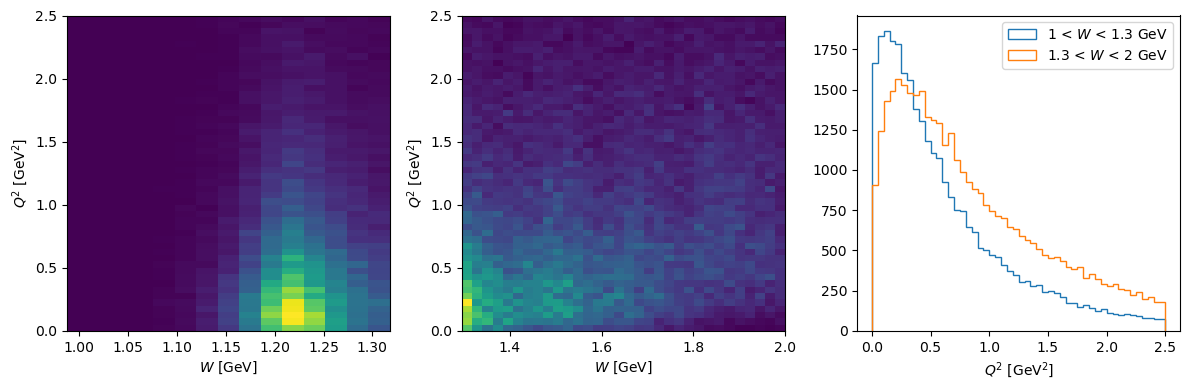

In [15]:
fig, axes = plt.subplots(1,3, figsize=(12,4))

q0q3_h.slice(0, [1,1.3]).mpl().colormesh(column="CC1$\pi^{+}$", plot_axis=axes[0])
q0q3_h.slice(0, [1.3,2]).mpl().colormesh(column="CC1$\pi^{+}$", plot_axis=axes[1])

q0q3_h.slice(0, [1,1.3]).project(1).mpl().hist(histtype="step", column="CC1$\pi^{+}$", label="1 < $W$ < 1.3 GeV", plot_axis=axes[2])
q0q3_h.slice(0, [1.3,2]).project(1).mpl().hist(histtype="step", column="CC1$\pi^{+}$", label="1.3 < $W$ < 2 GeV", plot_axis=axes[2])

fig.tight_layout()
plt.legend()
plt.show()

**N.B.** The slice functions above include the bins in which the ends of the ranges fall, and all bins between. Bins in the sliced dimension are never split. Passing a single value, like:

```python
q0q3_h.slice(0, 1.25)
```
will select a single bin along axis 0 and produce a 1D histogram. If a range is given, and multiple bins are selected in the sliced dimension, then a 2D histogram will be produced.

# Cross Section Predictions

So far we have been making histograms of events. Ultimately, we want to produce cross section predictions. To do this, we need to normalise by the FATX of the generator run. NUISANCE3 tries to make this as painless as possible. We can get the FATX/sum of event weights, which is the quantity we will need to scale a histogram of event properties by to get the normalisation correct. The final step is to divide by the width of each bin so that the area under the 'histogram' integrates to equal the fraction of the FATX for the events included in the histogram (if cuts are applied).

We retrieve the FATX/sumweights from the event stream *after* it has been processed. We have to be careful to retrieve the `norm_info` object when the reading of the events has completed, if we accidentally restart the event stream by calling `first` or looping on events from it, the `norm_info` will not be correct for the `EventFrame` we have produced. Its best to re-build the EventFrame from scratch and then store the FATX information immediately.

When retrieving the `norm_info`, we must specify the units we want the FATX in. A common convention is $10^{-38} \mathrm{cm}^{2} /\mathrm{Nucleon}$. The pyNuHepMC library has constants defining common unit conventions that we can use, as below.

In [17]:
ef = efg.all()
gnorm = gevs.norm_info(pn.nhm.FATXUtils.cm2ten38_PerNucleon)

print(f"GENIE FATX = {gnorm.fatx:.5f} cm^2 10^-38 /N")

GENIE FATX = 3.52922 cm^2 10^-38 /N
[warning]: Untranslated NEUT code: 39
[EventInput:warning]: xs(E = 2.5727698699472477, probe = 14, tgt = 11) = 0
[warning]: Untranslated NEUT code: 39
[warning]: Untranslated NEUT code: 39
[warning]: Untranslated NEUT code: 39
[warning]: Untranslated NEUT code: 39
[warning]: Untranslated NEUT code: 39
[warning]: Untranslated NEUT code: 39
[warning]: Untranslated NEUT code: 39
[EventInput:warning]: xs(E = 4.343511896893922, probe = 14, tgt = 11) = 0
[EventInput:warning]: xs(E = 2.476613548819088, probe = 14, tgt = 11) = 0
[warning]: Untranslated NEUT code: 39
[warning]: Untranslated NEUT code: 39
[warning]: Untranslated NEUT code: 39
[warning]: Untranslated NEUT code: 39
[warning]: Untranslated NEUT code: 39
[warning]: Untranslated NEUT code: 39
[warning]: Untranslated NEUT code: 39
[warning]: Untranslated NEUT code: 39
[EventInput:warning]: xs(E = 4.461827956771302, probe = 14, tgt = 11) = 0
[warning]: Untranslated NEUT code: 39
[EventInput:warning]:

Now we can make a differential cross section prediction, as below:

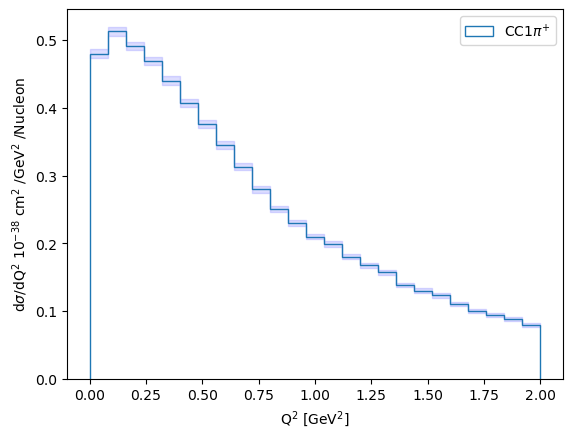

In [21]:
Q2_h = pn.HistFrame(pn.Binning.lin_space(0,2,25,r"Q$^{2}$ [GeV$^{2}$]"), "Total")
Q2_h.fill(ef, "Q2", [pn.HistFrame.fill_column("Total"), 
                     pn.HistFrame.categorize_by("pioncategory", 
                                                  ["CC0$\pi$", "CC1$\pi^{+}$", "CC1$\pi^{-}$", "CC1$\pi^{0}$", "CCN$\pi$"])])
Q2_h.scale(gnorm.fatx_per_sumweights()).finalise(True).mpl().hist(histtype="step", column="CC1$\pi^{+}$", errorband_color="#00F2")
plt.ylabel("d$\sigma$/dQ$^{2}$ 10$^{-38}$ cm$^{2}$ /GeV$^{2}$ /Nucleon")

plt.legend()
plt.show()

# Calculate Some Weights

In [11]:
%%bash

cat > tool_config.fcl << EOF

ResIso_config: {
    tool_type: "ResIso"

    alldial_variation_descriptor: "(-3,3,1)"
  }

syst_providers: [ResIso_config]

EOF

GenerateSystProviderConfigNuSyst -c tool_config.fcl -o tool_headers_prolog.fcl
cat tool_headers_prolog.fcl | grep -v "PROLOG" > tool_headers.fcl
head tool_headers.fcl

[GenerateSystProviderConfigNuSyst] input
ResIso_config: {
   alldial_variation_descriptor: "(-3,3,1)"
   tool_type: "ResIso"
}
syst_providers: [
   "ResIso_config"
]

1734467857 NOTICE Messenger : [s] <SetPrioritiesFromXmlFile (136)> : Reading msg stream priorities from XML file: /opt/genie/3_04_02/config/Messenger.xml
1734467857 INFO TuneId : [n] <TuneId.cxx::Build (132)> : AR23_20i_00_000 Tune configured 
1734467857 INFO RunOpt : [n] <RunOpt.cxx::BuildTune (94)> : Building tune AR23_20i_00_000
1734467857 INFO TuneId : [n] <TuneId.cxx::Build (132)> : AR23_20i_00_000 Tune configured 
Wrote systematic provider configuration with md5: "7055e3eca02f8640ecedcbf7c7088e1d" to "tool_headers_prolog.fcl"
generated_systematic_provider_configuration: {
   ResIso: {
      MaRes_ResCode0: {
         isSplineable: true
         paramVariations: [
            -3,
            -2,
            -1,
            0,
            1,


In [12]:
%%bash
DumpConfiguredTweaksNuSyst -i genie_ar40.ghep.root -N 10 -c tool_headers.fcl -o bla.root

1734467857 NOTICE Messenger : [s] <SetPrioritiesFromXmlFile (136)> : Reading msg stream priorities from XML file: /opt/genie/3_04_02/config/Messenger.xml
1734467857 INFO TuneId : [n] <TuneId.cxx::Build (132)> : AR23_20i_00_000 Tune configured 
1734467857 INFO RunOpt : [n] <RunOpt.cxx::BuildTune (94)> : Building tune AR23_20i_00_000
1734467857 INFO TuneId : [n] <TuneId.cxx::Build (132)> : AR23_20i_00_000 Tune configured 
[INFO]: Syst provider "ResIso" configured 36 parameters.


I/O warning : failed to load external entity "Messenger_whisper.xml"


Event #9/10, Interaction: nu:14;tgt:1000180400;N:2112;q:1(v);proc:Weak[CC],DIS;


In [14]:
wf = pn.WeightCalcFactory()

In [15]:
nusyst = wf.make(gevs, {"plugin_name": "nusystematics",
                       "param_headers": "tool_headers.fcl"})

[INFO]: Syst provider "ResIso" configured 36 parameters.


In [16]:
nusyst.set_parameters({"MaRes_ResCode0": 1})

In [17]:
evf = pn.EventFrameGen(gevs) \
        .add_column("enu_GeV", pn.pps.ext.enu_GeV) \
        .add_column("w", nusyst.calc_weight)

ef = evf.all()
print(ef)

 -----------------------------------------------------------------------------------------
 | event.number | weight.cv | fatx_per_su$ | fatx_per_su$ | process.id | enu_GeV |     w |
 -----------------------------------------------------------------------------------------
 |            0 |         1 |        4.877 |       0.1219 |        550 |   12.29 |     1 |
 |            1 |         1 |        2.043 |      0.05108 |        550 |   8.688 |     1 |
 |            2 |         1 |       0.4553 |      0.01138 |        450 |   1.197 |     1 |
 |            3 |         1 |       0.4123 |      0.01031 |        500 |   10.92 |     1 |
 |            4 |         1 |        0.389 |     0.009725 |        650 |   17.63 |     1 |
 |            5 |         1 |       0.3673 |     0.009182 |        650 |   16.78 |     1 |
 |            6 |         1 |       0.3506 |     0.008764 |        600 |   19.78 |     1 |
 |            7 |         1 |       0.3327 |     0.008319 |        600 |   16.71 |     1 |

# Compare to some data

We're going to start by comparing to some NUISANCE2 data from MINERvA. First we need to choose a sample. The `nuissamples` script can be used to say all of the samples that NUISANCE2 knows about.

In [19]:
%%bash
nuissamples MINERvA | grep "pi" | grep -v "0pi"

MINERvA_CC1pip_XSec_1DTpi_nu
MINERvA_CC1pip_XSec_1DTpi_nu_20deg
MINERvA_CC1pip_XSec_1DTpi_nu_fluxcorr
MINERvA_CC1pip_XSec_1DTpi_nu_20deg_fluxcorr
MINERvA_CC1pip_XSec_1Dth_nu
MINERvA_CC1pip_XSec_1Dth_nu_20deg
MINERvA_CC1pip_XSec_1Dth_nu_fluxcorr
MINERvA_CC1pip_XSec_1Dth_nu_20deg_fluxcorr
MINERvA_CC1pip_XSec_1DTpi_nu_2017
MINERvA_CC1pip_XSec_1Dth_nu_2017
MINERvA_CC1pip_XSec_1Dpmu_nu_2017
MINERvA_CC1pip_XSec_1Dthmu_nu_2017
MINERvA_CC1pip_XSec_1DQ2_nu_2017
MINERvA_CC1pip_XSec_1DEnu_nu_2017
MINERvA_CC1pim_XSec_1DEnu_antinu
MINERvA_CC1pim_XSec_1DQ2_antinu
MINERvA_CC1pim_XSec_1DTpi_antinu
MINERvA_CC1pim_XSec_1Dpmu_antinu
MINERvA_CC1pim_XSec_1Dth_antinu
MINERvA_CC1pim_XSec_1Dthmu_antinu
MINERvA_CCNpip_XSec_1Dth_nu
MINERvA_CCNpip_XSec_1Dth_nu_2015
MINERvA_CCNpip_XSec_1Dth_nu_2016
MINERvA_CCNpip_XSec_1Dth_nu_2015_20deg
MINERvA_CCNpip_XSec_1Dth_nu_2015_fluxcorr
MINERvA_CCNpip_XSec_1DTpi_nu
MINERvA_CCNpip_XSec_1DTpi_nu_2015
MINERvA_CCNpip_XSec_1DTpi_nu_2016
MINERvA_CCNpip_XSec_1DTpi_nu_2015_20deg


Lets compare to `MINERvA_CC1pip_XSec_1DQ2_nu_2017`, we need to manually find some information out about the sample so that we can generate the right events for it. NUISANCE3 encapsulates that information in automatically parseable metadata, but for NUISANCE2 samples, we need to put in some leg work.

The sample implementation is here: https://github.com/NUISANCEMC/nuisance/blob/main/src/MINERvA/MINERvA_CC1pip_XSec_1D_2017Update.cxx
Data stored in NUISANCE here: https://github.com/NUISANCEMC/nuisance/tree/main/data/MINERvA/CC1pip/070717

We will need to generate some events with the MINERvA Low Energy flux on a hydrocarbon (CH) target

NUISANCE2 has copies of the flux histograms in ROOT format, we can use the `nuis-flux` script to build the argument we need for `gevgen`.

In [25]:
%%bash
$NUISANCE/bin/nuis-flux MINERvA -P numu -M nu

/root/software/NUISANCEMC/nuisance/build/Linux/data/flux/minerva_le_flux.root,numu_fhc


In [2]:
gevs = pn.EventSource({"event-generator-list":"Default",
                       "tune":"AR23_20i_00_000",
                       "spline_file":"/opt/genie_xsec/3_04_00/AR23_20i_00_000/gxspl-min.xml.gz",
                       "filepath": "genie_CH.MINERvA_LE.ghep.root"})

1734472384 NOTICE Messenger : [s] <SetPrioritiesFromXmlFile (136)> : Reading msg stream priorities from XML file: /opt/genie/3_04_02/config/Messenger.xml
1734472384 INFO TuneId : [n] <TuneId.cxx::Build (132)> : AR23_20i_00_000 Tune configured 
1734472384 INFO RunOpt : [n] <RunOpt.cxx::BuildTune (94)> : Building tune AR23_20i_00_000
1734472384 INFO TuneId : [n] <TuneId.cxx::Build (132)> : AR23_20i_00_000 Tune configured 
1734472385 INFO TransverseEnhancementFFModel : [n] <ConfigIsotopeMapUtils.cxx::LoadAllNucARangesForKey (61)> : For 0 < A < 12 -> using MagFF_RT_A = 0
1734472385 INFO TransverseEnhancementFFModel : [n] <ConfigIsotopeMapUtils.cxx::LoadAllNucARangesForKey (61)> : For 11 < A < 420 -> using MagFF_RT_A = 5.19
1734472385 INFO TransverseEnhancementFFModel : [n] <ConfigIsotopeMapUtils.cxx::LoadAllNucARangesForKey (61)> : For 0 < A < 12 -> using MagFF_RT_B = 1
1734472385 INFO TransverseEnhancementFFModel : [n] <ConfigIsotopeMapUtils.cxx::LoadAllNucARangesForKey (61)> : For 11 < A

In [3]:
rf = pn.RecordFactory()
nuis2 = rf.make_record({"type":"nuisance2"})
MINERvA_CC1pip_XSec_1DQ2_nu_2017 = nuis2.analysis("MINERvA_CC1pip_XSec_1DQ2_nu_2017")

[LOG Sample]:--  : Measurement1D.cxx::FinaliseMeasurement[l. 562] : Finalising Measurement: MINERvA_CC1pip_XSec_1DQ2_nu_2017
[Record:critical]: NUISANCE2Record::analysis(MINERvA_CC1pip_XSec_1DQ2_nu_2017)
[LOG Fitter]:  : SampleList.cxx::LoadPlugins[l. 449] : Searching for dynamic sample manifests in: /root/software/NUISANCEMC/notebooks/
[LOG Fitter]:  : SampleList.cxx::DynamicSampleFactory[l. 405] : Loaded 0 from 0 shared object libraries.
[LOG Sample]:--  : Measurement1D.cxx::FinaliseSampleSettings[l. 151] : Finalising Sample Settings: MINERvA_CC1pip_XSec_1DQ2_nu_2017
[LOG Sample]:--  : Measurement1D.cxx::SetDataFromTextFile[l. 203] : Reading data from text file: /root/software/NUISANCEMC/nuisance/build/Linux/data/MINERvA/CC1pip/070717/cc1pip_updated_1DQ2_data.txt
[LOG Sample]:--  : Measurement1D.cxx::SetCorrelationFromTextFile[l. 341] : Reading data correlations from text file: /root/software/NUISANCEMC/nuisance/build/Linux/data/MINERvA/CC1pip/070717/cc1pip_updated_1DQ2_ratecov.txt;8

[ERR WARN  ]: Allowing SVD inverse if matrices are singular, use with extreme caution!


In [17]:
evfgen = pn.EventFrameGen(gevs) \
            .filter(MINERvA_CC1pip_XSec_1DQ2_nu_2017.get_selection().op) \
            .add_column("Q2", MINERvA_CC1pip_XSec_1DQ2_nu_2017.get_projections()[0].op) \
            .add_column("w", nusyst.calc_weight)

ev_frame = evfgen.all()

nuevs_ni = gevs.norm_info(pn.nhm.FATXUtils.cm2ten38_PerNucleon)
fatx_ptn = nuevs_ni.fatx
sumweights = nuevs_ni.sumweights

print(fatx_ptn/sumweights)

3.5445281903460784e-05
[warning]: Untranslated NEUT code: 39
[warning]: Untranslated NEUT code: 39
[warning]: Untranslated NEUT code: 39


In [18]:
print(ev_frame.column_names)
print(ev_frame)

['event.number', 'weight.cv', 'fatx_per_sumw.pb_per_target.estimate', 'fatx_per_sumw.pb_per_nucleon.estimate', 'process.id', 'Q2', 'w']
 -----------------------------------------------------------------------------------------
 | event.number | weight.cv | fatx_per_su$ | fatx_per_su$ | process.id |      Q2 |     w |
 -----------------------------------------------------------------------------------------
 |            3 |         1 |      0.08973 |     0.007478 |        500 |  0.3684 |     1 |
 |           26 |         1 |      0.01081 |     0.001314 |        400 |  0.4963 | 1.223 |
 |           40 |         1 |     0.006449 |    0.0008756 |        400 | 0.08459 |  1.06 |
 |           41 |         1 |     0.006355 |     0.000855 |        400 |  0.7699 |  1.31 |
 |           57 |         1 |     0.004885 |    0.0006501 |        200 |    2.32 |     1 |
 |           70 |         1 |     0.002991 |     0.000525 |        400 | 0.04894 | 1.039 |
 |           84 |         1 |     0.002704 | 

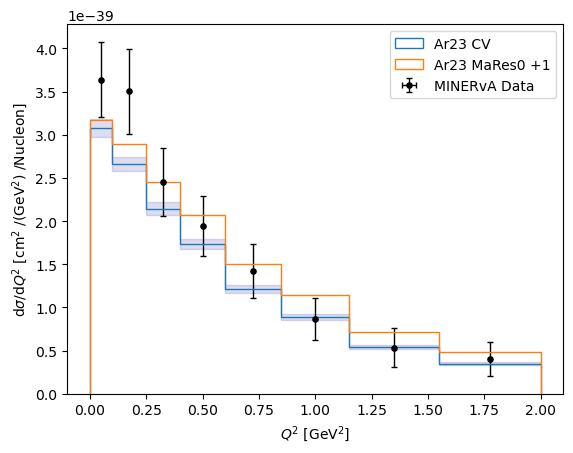

In [19]:
data = MINERvA_CC1pip_XSec_1DQ2_nu_2017.get_data()[0]

data.mpl().errorbar(marker=".", markersize=7.5, color="#000", label="MINERvA Data", linewidth=0, elinewidth=1, capsize=2.5)

mc = data.make_HistFrame()
mc_map1 = data.make_HistFrame()

mc.fill(ev_frame, ["Q2"], [ pn.HistFrame.fill_column(0) ])
mc_map1.fill(ev_frame, ["Q2"], [ pn.HistFrame.fill_column(0), pn.HistFrame.weight_by("w") ])

# #required because this analysis is in cm^2 /N not the nuisance2 default of 1E-38 cm2/N
ana_scale = 1E-38

mcpred = mc.finalise(True).scale(ana_scale * (fatx_ptn/sumweights))

mcpred_map1 = mc_map1.finalise(True).scale(ana_scale * (fatx_ptn/sumweights))

mcpred.mpl().hist(histtype="step", errorband_color="#0092", label="Ar23 CV")
mcpred_map1.mpl().hist(histtype="step", label="Ar23 MaRes0 +1")

plt.ylabel(r"d$\sigma$/d$Q^{2}$ [cm$^{2}$ /(GeV$^{2}$) /Nucleon]")
plt.xlabel(r"$Q^{2}$ [GeV$^{2}$]")

plt.legend()

plt.show()